# Data Loaders

There are two dataloaders available to make working with the provided data more straightforward. 

1. Data loader providing spectral data and labels for a single pixel. Useful for scikit-learn classifiers
2. Pytorch dataset and Pytorch Ligthning dataloader providing image chips together with labels

In this notebook we show how these data loaders can be used.

## Pixel data loader



In [1]:
from disfor.data import ForestDisturbanceData

The class `ForestDisturbanceData` provides arguments to filter the dataset and returns class properties which can be used for training of sklearn classifiers.

In [2]:
data = ForestDisturbanceData(
    # If None, data gets dynamically downloaded and cached from Huggingface
    data_folder=None,
    # selecting healthy forest (110), clear cut (211) and bark beetle (231)
    target_classes=[110, 211, 231],
    # we remap salvage logging (221 and 222) to also be part of the clear cut class
    class_mapping_overrides={221: 211, 222: 211},
    # suset to only include samples with high confidence
    confidence=["high"],
    # only include acquisitions from "leaf-on" months
    months=[5, 6, 7, 8, 9],
    # including also dark pixels (2) as valid
    valid_scl_values=[2, 4, 5, 6],
    # only include acquisitions where the clear cut is recent (maximum of 90 days),
    # for all other classes include everything
    max_days_since_event={211: 90},
    max_samples_per_event=5,
    # omit samples which have low tcd in the comment
    omit_low_tcd=True,
    # omit samples which have border in the comment
    omit_border=True,
)

Once initialized, the class instance provides train and test data as numpy arrays. 

In [3]:
print(data.y_train, data.X_train, data.y_test, data.X_test, sep="\n")

[0 0 0 ... 0 0 0]
[[ 245  516  561 ... 4265 2567 1417]
 [ 353  628  648 ... 4570 2475 1414]
 [ 275  546  664 ... 4411 2556 1405]
 ...
 [ 193  333  146 ... 3737 1374  597]
 [ 174  226  103 ... 2004  553  245]
 [ 228  350  194 ... 3847 1495  650]]
[0 0 0 ... 0 0 0]
[[1136 1490 1604 ... 2288 2277 1760]
 [1011 1358 1458 ... 2384 2243 1830]
 [1058 1442 1556 ... 2514 2307 1745]
 ...
 [ 190  398  224 ... 1943  957  473]
 [ 419  534  311 ... 2495 1044  491]
 [ 242  416  264 ... 2416 1347  667]]


It also provides the used label encoder, to go from the 0 to n-1 encoded labels back to the original labels.  

In [4]:
data.label_encoder.inverse_transform(data.y_test)

array([110, 110, 110, ..., 110, 110, 110], shape=(7482,), dtype=uint16)

Now, let's very quickly train a Random Forest model and validate the output:

In [5]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(oob_score=True)
rf.fit(data.X_train, data.y_train)

print(rf.oob_score_)

0.9109323801012809


The out of box accuracy for the Random Forest model is 0.9. However let's use the held out set to get a better idea of the model accuracy. For this we apply the trained model on the held out predictors (`X_test`) and derive accuracy metrics from this.

              precision    recall  f1-score   support

         110       0.98      0.91      0.95      6806
         211       0.43      0.73      0.54       241
         231       0.43      0.76      0.55       435

    accuracy                           0.90      7482
   macro avg       0.62      0.80      0.68      7482
weighted avg       0.93      0.90      0.91      7482



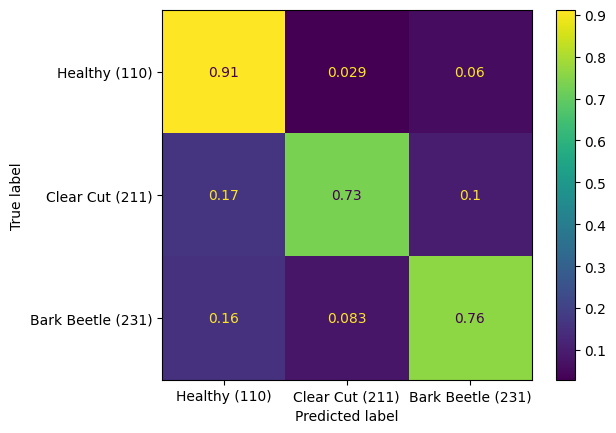

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_pred = rf.predict(data.X_test)
print(
    classification_report(
        data.y_test, y_pred, target_names=data.label_encoder.classes_.astype(str)
    )
)

disp = ConfusionMatrixDisplay.from_predictions(
    data.y_test, y_pred,
    display_labels=['Healthy (110)', 'Clear Cut (211)', 'Bark Beetle (231)'],
    normalize="true"
)

We can see that the healthy class is predicted well, however the other two classes are not predicted particularly well. Especially the precision is not great.

## Pytorch dataloader

The pytorch dataloader is used for loading image chips. If it is the first time loading the data, it will be downloaded from Huggingface. For this at least 100GB of free disk space is necessary. After the first time loading, around 60GB of space will be used. 

The first data loading can take quite some time to download and extract the data.

In [1]:
from disfor.torch import TiffDataset

tiff_dataset = TiffDataset(
    # If None, data gets dynamically downloaded and cached from Huggingface
    data_folder=None,
    # selecting healthy forest (110), clear cut (211) and bark beetle (231)
    target_classes=[110, 211, 231],
    # reduce the size of the chip, to include less context
    chip_size=8,
    # subset to only include samples with high confidence
    confidence=["high"],
    # only include acquisitions from "leaf-on" months
    months=[5, 6, 7, 8, 9],
    # only include acquisitions where the clear cut is recent (maximum of 90 days),
    # for all other classes include everything
    max_days_since_event={211: 90},
    # omit samples which have low tcd in the comment
    omit_low_tcd=True,
    # omit samples which have border in the comment
    omit_border=True,
)

The dataset returns a dictionary with the image, label and path of the image.

In [2]:
tiff_dataset[0]

{'image': tensor([[[0.0222, 0.0152, 0.0125, 0.0140, 0.0178, 0.0216, 0.0246, 0.0267],
          [0.0461, 0.0432, 0.0426, 0.0307, 0.0243, 0.0237, 0.0263, 0.0332],
          [0.0309, 0.0379, 0.0484, 0.0453, 0.0422, 0.0438, 0.0375, 0.0485],
          [0.0247, 0.0251, 0.0239, 0.0263, 0.0310, 0.0322, 0.0309, 0.0417],
          [0.0242, 0.0249, 0.0278, 0.0256, 0.0245, 0.0231, 0.0191, 0.0242],
          [0.0267, 0.0203, 0.0212, 0.0235, 0.0228, 0.0235, 0.0250, 0.0219],
          [0.0328, 0.0237, 0.0208, 0.0203, 0.0207, 0.0209, 0.0260, 0.0296],
          [0.0433, 0.0354, 0.0337, 0.0295, 0.0260, 0.0246, 0.0208, 0.0238]],
 
         [[0.0525, 0.0480, 0.0430, 0.0425, 0.0403, 0.0424, 0.0466, 0.0508],
          [0.0641, 0.0631, 0.0645, 0.0557, 0.0531, 0.0548, 0.0521, 0.0406],
          [0.0659, 0.0664, 0.0830, 0.0653, 0.0638, 0.0703, 0.0727, 0.0912],
          [0.0566, 0.0545, 0.0532, 0.0567, 0.0608, 0.0600, 0.0477, 0.0691],
          [0.0585, 0.0539, 0.0505, 0.0543, 0.0516, 0.0512, 0.0503, 0.0522],


The image can also be plotted. 

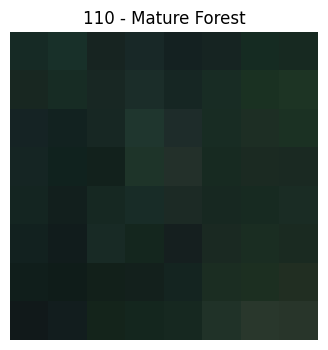

In [3]:
tiff_dataset.plot_chip(59200)

### Pytorch Lightning

For use with Pytorch Lightning, a Lightning datamodule is also available. This datamodule takes care of splitting the dataset into a training and validation set, so that the training progress can be monitored.

The datamodule only takes a few extra parameters, like `batch_size`, `num_workers` and `persist_workers`. All of the reminaing parameters are passed as keyword arguments to `TiffDataset`.

In [4]:
from disfor.torch import TiffDataModule

tiff_datamodule = TiffDataModule(
    batch_size=64,
    num_workers=6,
    # Keyword arguments are passed to TiffDataset
    # selecting healthy forest (110), clear cut (211) and bark beetle (231)
    target_classes=[110, 211, 231],
    # reduce the size of the chip, to include less context
    chip_size=8,
    # subset to only include samples with high confidence
    confidence=["high"],
    # only include acquisitions from "leaf-on" months
    months=[5, 6, 7, 8, 9],
    # only include acquisitions where the clear cut is recent (maximum of 90 days),
    # for all other classes include everything
    max_days_since_event={211: 90},
    # omit samples which have low tcd in the comment
    omit_low_tcd=True,
    # omit samples which have border in the comment
    omit_border=True,
)

To test this datamodule we are defining a very simple neural network to predict classes from the input images.

In [14]:
import torch
import torch.nn as nn
import lightning as L

class SimpleClassifier(L.LightningModule):
    def __init__(self, num_classes=2, lr=1e-3):
        super().__init__()
        self.lr = lr
        
        # Simple feedforward network
        # Input: 10 channels * 8 * 8 = 640 features
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(10 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )
        
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch['image'], batch['label']
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss, prog_bar=True, batch_size=len(batch['label']))
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch['image'], batch['label']
        logits = self(x)
        loss = self.criterion(logits, y)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        self.log('val_loss', loss, prog_bar=True, batch_size=len(batch['label']))
        self.log('val_acc', acc, prog_bar=True, batch_size=len(batch['label']))
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

Finally we train the neural net using the data from our datamodule. As an example we are only going for 10 epochs.

In [15]:
model = SimpleClassifier(num_classes=3, lr=1e-3)

# Train with your dataloader
trainer = L.Trainer(max_epochs=10)
trainer.fit(model, datamodule=tiff_datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jonas/Documents/Projects/2025/DISFOR/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     |

/home/jonas/Documents/Projects/2025/DISFOR/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 9: 100%|██████████| 820/820 [01:18<00:00, 10.49it/s, v_num=7, train_loss=0.031, val_loss=0.127, val_acc=0.956] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 820/820 [01:18<00:00, 10.49it/s, v_num=7, train_loss=0.031, val_loss=0.127, val_acc=0.956]


Now, let's look at the confusion matrix of the trained neural net:

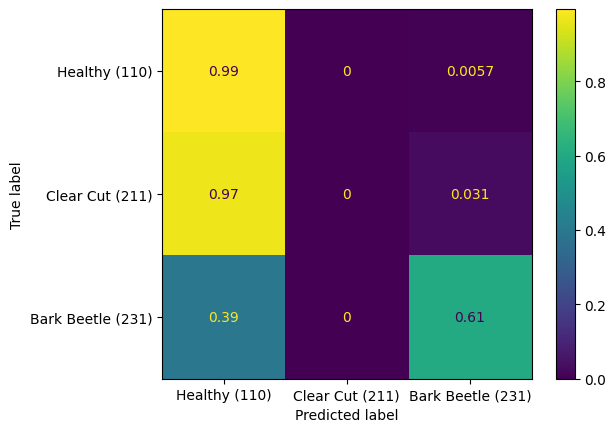

In [24]:
# After training, run validation and collect predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tiff_datamodule.val_dataloader():
        x, y = batch['image'], batch['label']
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())


disp = ConfusionMatrixDisplay.from_predictions(
    all_labels, all_preds,
    display_labels=['Healthy (110)', 'Clear Cut (211)', 'Bark Beetle (231)'],
    normalize="true"
)